<h1 style="text-align: center; vertical-align: middle;">Introduction to neural networks</h1>

<h3 style="text-align: center; vertical-align: middle; margin-top: 1em; margin-bottom: 1em;"> Tutorial by Dr. Andrea Santamaria Garcia and Chenran Xu</h3>

<div style="width: 50%; horizontal-align: middle; vertical-align: middle; ">
<img src="./img/KIT_logo.svg" style="width: 30%; float: right; vertical-align: center;" />
</div>
<div style="clear: both; vertical-align: middle;"></div>

# Get the repository with Git

You will need to have Git previously installed in your computer.
To check if you have it installed, open your terminal and type:

``` bash
git --version
```

## Git installation in mac

``` bash
brew update
brew install git
```

## Git installation in linux

In Ubuntu/Debian

``` bash
sudo apt install git
```

## Download the repository

Once you have Git installed open your terminal, go to your desired directory, and type:

``` bash
git clone https://github.com/machine-learning-tutorial/neural-networks
cd neural-networks
```

Or get the repository with direct download:

``` bash
wget https://github.com/machine-learning-tutorial/neural_networks/archive/refs/heads/main.zip
unzip main.zip
cd neural-networks
```

# Install dependencies

You need to install the dependencies before running the notebooks.

## Using conda

If you don't have conda installed already and want to use conda for environment management, you can install the miniconda as [described here](https://docs.conda.io/projects/miniconda/en/latest/miniconda-install.html).

Then run the following commands:

```bash
conda create -n nn-tutorial python=3.10
conda activate nn-tutorial
pip install -r requirements.txt
jupyter contrib nbextension install --user
jupyter nbextension enable varInspector/main
```

- After the tutorial you can remove your environment with `conda remove -n nn-tutorial --all`

# Install dependencies

You need to install the dependencies before running the notebooks.

## Using venv only

If you do not have conda installed:

Alternatively, you can create the virtual env with `venv` in the standard library

```bash
python -m venv nn-tutorial
```

and activate the env with $ source <venv>/bin/activate (bash) or C:> <venv>/Scripts/activate.bat (Windows)

Then, install the packages with pip within the activated environment


```bash
python -m pip install -r requirements.txt
jupyter contrib nbextension install --user
jupyter nbextension enable varInspector/main
```

# Running the tutorial

You can start the notebook in the terminal, and it will start a browser automatically

```bash
jupyter notebook
```

Alternatively, you can use supported Editor to run the jupyter notebooks, e.g. with VS Code.

<h1>Run this first!</h1>

Imports and modules:

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import h5py
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats, display

plt.rcParams['figure.figsize'] = 6, 4
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['image.cmap'] = "viridis"
plt.rcParams['image.interpolation'] = "none"
plt.rcParams['savefig.bbox'] = "tight"

## Reproducibility

- We set the random seeds so that the training results are always the same
- Feel free to change the seed number to see the effects of the random initialization of the network weights on the training results

In [2]:
SEED = 50
torch.manual_seed(SEED)
torch.backends.openmp.deterministic = True
np.random.seed(SEED)

## Conventions for this notebook

### Jargon

- Unit = activation = neuron
- Model = neural network
- Feature = dimension of input vector = number of independent variables
- Hypothesis = prediction = output of the model

### Indices

- **Data points:** $i = 1,..., n$ 
- **Parameters of the model:** $k = 1,..., p$ 
- **Layers:** $j = 1,..., l$ 
- **Activation unit label:** $s$ 

### Scalars

- $u^j$ = number of units in layer $j$
- $z_s^j$ is the activation unit $s$ in layer $j$

## Conventions for this notebook

### Vectors and matrices

- $\pmb{X}$: input vector of dimension $[n \times (p \times 1)]$
- $z^j$: activation vector of layer $j$ of dimension $[(u^j + 1) \times 1]$
- $\pmb{w}^j$: weight matrix from layer $j$ to $j+1$, of dimension $[u^{j+1} \times (u^j + 1)]$


<span style='color:Blue'> where the $+1$ accounts for the bias unit </span>


$$
\pmb{X} =
\begin{bmatrix}
x_0 \\
x_1 \\
\vdots \\
x_p
\end{bmatrix} \ \ ; \ \
\pmb{w}^j =
\begin{bmatrix}
w_{10} & \dots & w_{1(u^j + 1)}\\
w_{20} & \ddots\\
\vdots \\
w_{(u^{j+1}) 0} & & w_{(u^{j+1})(u^j + 1)}\\
\end{bmatrix} 
$$

## Universal Approximation Theorem
- When the activation function is non-linear, then a two-layer neural network can be proven to be a **universal function approximator**.
- <span style='color:red'> This is where the power of neural networks comes from! </span>

## Create a function to fit
Let's create a simple non-linear function to fit with our neural network:

Text(0.5, 1.0, 'Function to be fitted')

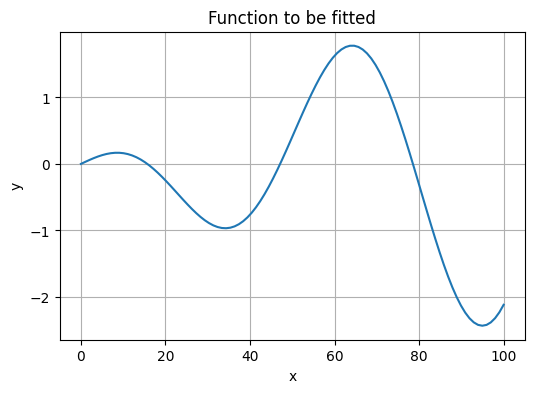

In [3]:
sample_points = 1e2
x_lim = 100
x = np.linspace(0, x_lim, int(sample_points))
y = np.sin(x * x_lim * 1e-4) * np.cos(x * x_lim * 1e-3) * 3
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.title('Function to be fitted')

## Data shape
- Our data is 1D, meaning it has only one feature.
- We want a model that for a given $x$ it returns the correspondent $y$ value.
- This means that a model with one neuron input and a one neuron output suffices:

In [4]:
n_input = 1
n_out = 1

In order for the model to take each point of the data one by one we need to do some additional re-shaping, where we introduce an additional dimension for each entry:

In [5]:
x_reshape = x.reshape((int(len(x) / n_input), n_input))
y_reshape = y.reshape((int(len(y) / n_out), n_out))

In [6]:
# # Uncomment to check the shape change
# print(x.shape, y.shape)
# print(x_reshape.shape, y_reshape.shape)
# print(x[10], x_reshape[10])

<h2>PyTorch</h2>

<a href="https://pytorch.org/">PyTorch</a> is an optimized tensor library for deep learning using GPUs and CPUS.
- A <span style='color:#b51f2a'> **tensor** </span> is an algebraic object that may map between different objects such as vectors, scalars, and even other tensors. It can be easily understood as a multidimensional matrix/array. 
    - These objects allow to easily carry out machine learning computations in problems with many features, weights, etc.
    - In PyTorch, a <a href="https://pytorch.org/docs/stable/tensors.html#:~:text=A%20torch.,of%20a%20single%20data%20type.">tensor</a> is a multi-dimensional matrix containing elements of a single data type.

<img src="img/tensor_2.jpeg" style="width:50%; margin:auto;" />
<p style="clear:both; font-size: small; text-align: center; margin-top:1em;">image from <a href="https://towardsai.net/p/deep-learning/working-with-pytorch-tensors">Working with PyTorch tensors</a></p>

## Data type
The data that we will input to the model needs to be of the type `torch.float32`

_Side Remark_: The default dtype of torch tensors (also the layer parameters) is `torch.float32`, which is related to the GPU performance optimization. If one wants to use `torch.float64`/`torch.double` instead, one can set the tensors to double precision via `v = v.double()` or set the global precision via `torch.set_default_dtype(torch.float64)`. Just keep in mind, the NN parameters and the input tensors should have the same precision.

Before starting, let's convert our data numpy arrays to torch tensors:

In [7]:
x_torch = torch.from_numpy(x_reshape)
y_torch = torch.from_numpy(y_reshape)

In [8]:
# Type checking:
print(x.dtype, y.dtype)
print(x_torch.dtype, y_torch.dtype)

float64 float64
torch.float64 torch.float64


The type is still not correct, but we can easily convert it:

In [9]:
x_torch = x_torch.to(dtype=torch.float32)
y_torch = y_torch.to(dtype=torch.float32)

In [10]:
# Type checking:
print(x.dtype, y.dtype)
print(x_torch.dtype, y_torch.dtype)

float64 float64
torch.float32 torch.float32


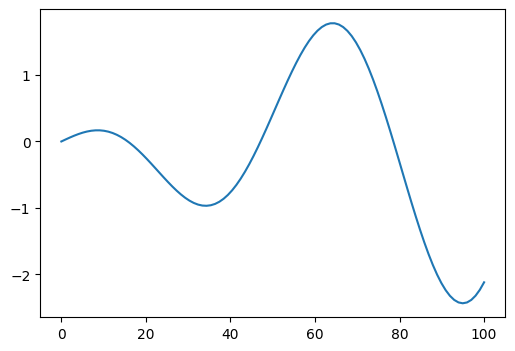

In [11]:
plt.plot(x_torch.numpy(), y_torch.numpy())

## Data normalization
We will also need to normalize the data to make sure we are in the non-linear region of the activation functions:

<img src="img/activation-functions.png" width="85%"/>

We are using min-max normalization to normalize the input tensors to [0,1] and output tensors to [-0.5,0.5]

In [12]:
x_norm = (x_torch - x_torch.min()) / (x_torch.max() - x_torch.min())
y_norm = (y_torch - y_torch.min()) / (y_torch.max() - y_torch.min()) - 0.5

Text(0.5, 1.0, 'Normalized function')

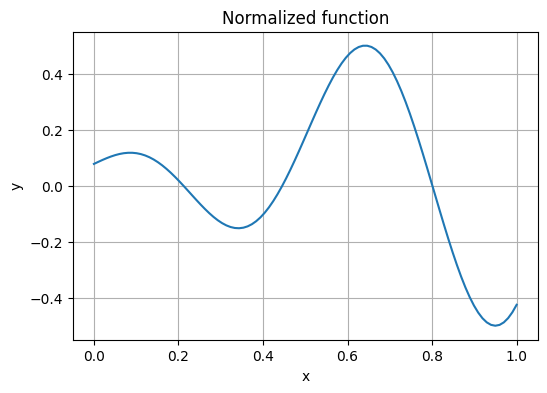

In [13]:
plt.plot(x_norm.detach().numpy(), y_norm.detach().numpy())
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.title('Normalized function')

In [14]:
x_norm.shape

torch.Size([100, 1])

## Build your model
- In PyTorch [`Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential) stands for *sequential container*, where modules can be added sequentially and are connected in a cascading way. The output for each module is forwarded sequentially to the next.
- Now we will build a simple model with one hidden layer with `Sequential`
- Remember that every layer in a neural network is followed by an **activation layer** that performs some additional operations on the neurons.

### Let's build 3 different models

### Model 0

A small model with small non-linearity

In [15]:
n_hidden_01 = 5

model0 = nn.Sequential(nn.Linear(n_input, n_hidden_01),
                      nn.LeakyReLU(),
                      nn.Linear(n_hidden_01, n_out),
                      )
print(model0)

Sequential(
  (0): Linear(in_features=1, out_features=5, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=5, out_features=1, bias=True)
)


### Model 1

A small model with some non-linearity

In [16]:
n_hidden_11 = 5

model1 = nn.Sequential(nn.Linear(n_input, n_hidden_11),
                      nn.Tanh(),
                      nn.Linear(n_hidden_11, n_out),
                      )
print(model1)

Sequential(
  (0): Linear(in_features=1, out_features=5, bias=True)
  (1): Tanh()
  (2): Linear(in_features=5, out_features=1, bias=True)
)


### Model 2

A larger model with non-linearity

In [17]:
n_hidden_21 = 10
n_hidden_22 = 5
model2 = nn.Sequential(nn.Linear(n_input, n_hidden_21),
                      nn.Tanh(),
                      nn.Linear(n_hidden_21, n_hidden_22),
                      nn.Tanh(),
                      nn.Linear(n_hidden_22, n_out),
                      )
print(model2)

# model2 = nn.Sequential(nn.Linear(n_input, n_hidden_21),
#                       nn.LeakyReLU(),
#                       nn.Linear(n_hidden_21, n_hidden_22),
#                       nn.LeakyReLU(),
#                       nn.Linear(n_hidden_22, n_out),
#                       )
# print(model2)

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Tanh()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): Tanh()
  (4): Linear(in_features=5, out_features=1, bias=True)
)


<h3 style="color:#e6541a;">How much do you think each hyperparameter will affect the quality of the model</h3>
<p style="color:#e6541a;">$\implies$ uncomment and execute the next line to explore the methods of the <code>model</code> object you created

In [18]:
# dir(model0)

## Understanding the PyTorch model
Try the `parameters` method (needs to be instantiated).

In [19]:
model0.parameters()

<generator object Module.parameters at 0x145cc33e0>

The `parameters` method gives back a *generator*, which means it needs to be iterated over to give back an output:

In [20]:
for element in model0.parameters():
    print(element.shape)

torch.Size([5, 1])
torch.Size([5])
torch.Size([1, 5])
torch.Size([1])


<h3 style="color:#e6541a;">Without taking into account any bias unit: can you identify the elements of the model by their dimensions?</h3>
<p style="color:#e6541a;">$\implies$ The first element corresponds to the weight matrix $\theta^0$ from layer 0 to layer 1, of dimensions $u^{j+1} \times u^j = u^2 \times u^1$ (so, without bias)</p>
<p style="color:#e6541a;">$\implies$ The second element corresponds to the values of the activation units in layer 1</p>
<p style="color:#e6541a;">$\implies$ The third element corresponds to the weight matrix $\theta^1$ from layer 1 to layer 2, of dimensions $u^{j+1} \times u^j = u^3 \times u^3 $ (without bias)</p>
<p style="color:#e6541a;">$\implies$ The fourth element is the output of the model</p>

Let's have a look at what the contents of those tensors:

In [21]:
for element in model0.parameters():
    print(element)

Parameter containing:
tensor([[ 0.2360],
        [-0.8626],
        [-0.2214],
        [-0.9192],
        [-0.1974]], requires_grad=True)
Parameter containing:
tensor([-0.7117, -0.0791, -0.0246,  0.1853,  0.9268], requires_grad=True)
Parameter containing:
tensor([[-0.3372, -0.0852, -0.0014,  0.4461,  0.0938]], requires_grad=True)
Parameter containing:
tensor([0.0205], requires_grad=True)


<h3 style="color:#e6541a;">What are these values?</h3>

## Define the loss function
- Reminder: the **loss function** measures how distant the predictions made by the model are from the actual values
- `torch.nn` provides many different types of [loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions). One of the most popular ones in the [Mean Squared Error (MSE)](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) since it can be applied to a wide variety of cases.
- In general cost functions are chosen depending on desirable properties, such as convexity.

In [22]:
loss_function = nn.MSELoss()

## Define the optimizer
[`torch.optim`](https://pytorch.org/docs/stable/optim.html) provides implementations of various optimization algorithms. The optimizer object will hold the current state and will update the parameters of the model based on computer gradients. It takes as an input an iterable containing the model parameters, that we explored before.

In [23]:
batch_size = 64 # how many points to pass to the model at a time
learning_rate = 1e-2

In [24]:
optimizer0 = torch.optim.Adam(model0.parameters(), lr=learning_rate)
optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [25]:
# optimizer0 = torch.optim.SGD(model0.parameters(), lr=learning_rate)
# optimizer1 = torch.optim.SGD(model1.parameters(), lr=learning_rate)
# optimizer2 = torch.optim.SGD(model2.parameters(), lr=learning_rate)

## Train the models on a loop
The model learns iteratively in a loop of a given number of epochs. Each loop consists of:
- A **forward propagation**: compute $y$ given the input $x$ and current weights and calculate the loss
- A **backward propagation**: compute the gradient of the loss function (error of the loss at each unit)
- Gradient descent: update model weights

In [26]:
# Define the training loop
def training_loop(x_train, y_train, model, optimizer, epochs:int=500):
    losses = []
    for epoch in range(epochs):
        pred_y = model(x_train)  # Forward pass
        optimizer.zero_grad()
        loss = loss_function(pred_y, y_train)
        losses.append(loss.item())
        loss.backward()  # Back-prop
        optimizer.step()
    return losses

In [27]:
# Run the training for all the models

losses0 = training_loop(x_norm, y_norm, model0, optimizer0, epochs=500)
losses1 = training_loop(x_norm, y_norm, model1, optimizer1, epochs=500)
losses2 = training_loop(x_norm, y_norm, model2, optimizer2, epochs=500)

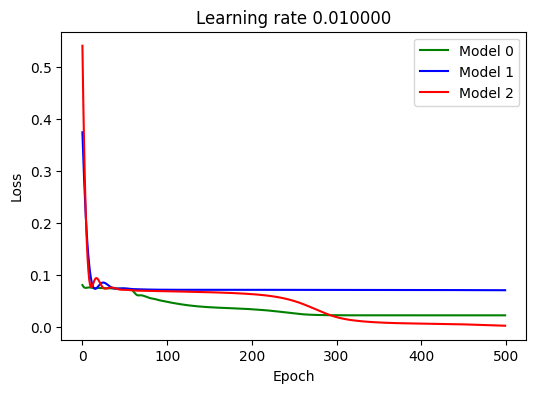

In [28]:
plt.plot(losses0, label='Model 0', color='green')
plt.plot(losses1, label='Model 1', color='blue')
plt.plot(losses2, label='Model 2', color='red')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.legend()
plt.show()

## Test the trained model
- Let's create some random points in the x-axis within the model's interval that will serve as test data.
- We will do the same data manipulations as before.

In [29]:
test_points = 50
x_test = np.random.uniform(0, np.max(x_norm.detach().numpy()), test_points)
x_test_reshape = x_test.reshape((int(len(x_test) / n_input), n_input))
x_test_torch = torch.from_numpy(x_test_reshape)
x_test_torch = x_test_torch.to(dtype=torch.float32)

Now we predict the y-value with our model:

In [30]:
y0_test_torch = model0(x_test_torch)
y1_test_torch = model1(x_test_torch)
y2_test_torch = model2(x_test_torch)

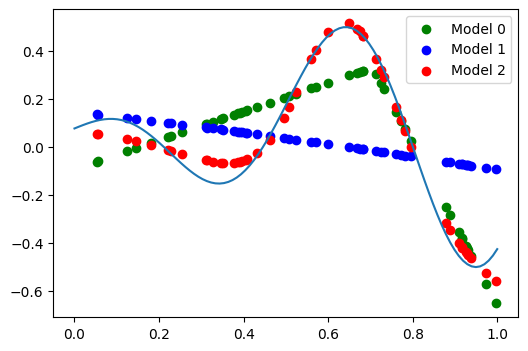

In [31]:
plt.plot(x_norm.detach().numpy(), y_norm.detach().numpy())
plt.scatter(x_test_torch.detach().numpy(), y0_test_torch.detach().numpy(), color='green', label='Model 0')
plt.scatter(x_test_torch.detach().numpy(), y1_test_torch.detach().numpy(), color='blue', label='Model 1')
plt.scatter(x_test_torch.detach().numpy(), y2_test_torch.detach().numpy(), color='red', label='Model 2')
plt.legend()
plt.show()

## Play with the notebook!
Some ideas:
- Change the number of epochs in `Section 5` to 5000 and re-train the models. What happens?
- Change the random seed in the `Reproducibility` cell at the very top. How do the results change?
- Change the optimizer in `Section 4` from `Adam` to `SGD` and re-train the models. What happens?
- [**if time allows, takes several minutes**] Change the epochs in `Section 5` to 1000000. What happens?
- Go back to 1000 epochs and the Adam optimizer. Change the learning rate in `Section 4` to 0.05. How do the results change? what does it tell us about our previous value?
- Change the learning rate to 0.5. What happens now?


<h3 style="color:#e6541a;">Comment on the results</h3>